In [1]:
"""
Questo script prende in input un file txt in cui sono salvate le inferenze calcolate dall'arduino nei vari test dei modelli di ML,
e confronta l'output dell'Arduino con quello riprodotto nell'audio di testing.

exptected è una lista di frames, ogni frame è un blocco temporale che contiene le informazioni di riproduzione del test audio
(ad esempio la categoria del suono riprodotto in quel momento)

i frame sono inseriti in una lista, per ogni inferenza contenuta nel file txt viene rintracciato il corrispettivo frame e viene confrontato
l'output dell'arduino con quello effettivamente riprodotto dal test. Vengono poi salvate le statistiche necessarie per lo studio del modello
che performa meglio.

"""
import os
import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

class Frame:

    #per ogni frame salvo momento di inizio e fine)
    def __init__(self, startm, starts, endm, ends, type):

        self.start   = datetime.time(0,startm,starts)
        self.end     = datetime.time(0,endm,ends)
        self.type    = type

    def print(self):
        print("Sample type: " + self.type +" "+ str(self.start)+"-"+str(self.end))

class Inference:

    def __init__(self, startm, starts, endm, ends, type, confidence):

        self.start   = datetime.time(0,startm,starts)
        self.end     = datetime.time(0,endm,ends)
        self.type   = type

        if type == "F":
            self.Fconf = confidence
            self.Nconf = float("{:.3f}".format(1 - confidence))
        elif type == "N":
            self.Fconf = float("{:.3f}".format(1 - confidence))
            self.Nconf = confidence
        else:
            self.Fconf = 0
            self.Nconf = 0

    def print(self):
            print("Predicted: " + self.type +" "+ str(self.start)+"-"+str(self.end) + " Fire score: " + str(self.Fconf) + " Noise score: " + str(self.Nconf))

def avg(array):

    avg = 0.0
    for i in range (0, len(array),1):
        avg+=array[i]
    if len(array)!= 0:
        avg  = float("{:.3f}".format((float(avg/len(array)))))
    return avg

rexpected = []

frame = Frame(0,0,0,15,"Invalid")
rexpected.append(frame)
frame = Frame(0,16,2,15,"Noise") #uccelli
rexpected.append(frame)
frame = Frame(2,16,4,15,"Fire3") #uccelli + fuoco3
rexpected.append(frame)
frame = Frame(4,16,6,15,"Noise") #grilli
rexpected.append(frame)
frame = Frame(6,16,8,15,"Fire3") #grilli + fuoco3
rexpected.append(frame)
frame = Frame(8,16,10,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(10,16,12,15,"Noise") #Vento
rexpected.append(frame)
frame = Frame(12,16,14,15,"Noise") #uccelli
rexpected.append(frame)
frame = Frame(14,16,16,15,"Fire3") #uccelli + fuoco3
rexpected.append(frame)
frame = Frame(16,16,18,15,"Noise") #insetti
rexpected.append(frame)
frame = Frame(18,16,20,15,"Fire3") #insetti + fuoco3
rexpected.append(frame)
frame = Frame(20,16,22,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(22,16,24,15,"Noise") #vento
rexpected.append(frame)
frame = Frame(24,16,26,15,"Fire3") #Campfire
rexpected.append(frame)
frame = Frame(26,16,28,15,"Fire2") #uccelli + fuoco2
rexpected.append(frame)
frame = Frame(28,16,30,15,"Fire2") #uccelli + fuoco2
rexpected.append(frame)
frame = Frame(30,16,32,15,"Noise") #uccelli
rexpected.append(frame)
frame = Frame(32,16,34,15,"Noise") #insetti
rexpected.append(frame)
frame = Frame(34,16,36,15,"Fire3") #campfire
rexpected.append(frame)
frame = Frame(36,16,40,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(40,16,44,15,"Fire2") #insetti + fuoco2
rexpected.append(frame)
frame = Frame(44,16,46,15,"Noise") #vento
rexpected.append(frame)
frame = Frame(46,16,48,15,"Fire1") #uccelli + fuoco1
rexpected.append(frame)
frame = Frame(48,16,50,15,"Fire1") #uccelli + fuoco1
rexpected.append(frame)
frame = Frame(50,16,54,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(54,16,58,15,"Fire1") #insetti + fuoco1
rexpected.append(frame)
frame = Frame(58,16,59,59,"Fire3") #Campfire
rexpected.append(frame)


file = "MFE-CONV1D-2C.txt" #filename to parse
treshold = 0.5
input = open(file,"r")


In [2]:

data = input.readlines()

inferences = []

for line in data:

    if line[0].isdigit():

        startmin = int(line[0:2])
        startsec = int(line[3:5])
        endmin   = int(line[6:8])
        endsec   = int(line[9:11])
        pred     = line[11]

        if pred == "D":
            score = 0
        else:
            score    = float("{:.3f}".format(float(line[13:18])))
        if pred == "N" and score<=(1-treshold):
            pred = "F"
            score = float("{:.3f}".format(1-treshold))
        inf      = Inference(startmin, startsec, endmin, endsec, pred, score)
        inferences.append(inf)

    else:
        continue



frame_index=0

noise_results = [] #quante volte arduino ha previsto noise
fire_results  = [] #quante volte arduino ha previsto fuoco
invalid = [] #campioni registrati a cavallo tra un frame di un tipo e uno di un altro tipo
uncertain = []
max_consecutive_fire_while_fire = 0
max_consecutive_fire_while_noise = 0
consecutive_fire_while_fire = []
consecutive_fire_while_noise = []
last_consecutive_index = 0
consec_fire = 0


for count, inf in enumerate(inferences):

    if inf.start>=rexpected[frame_index].end:
        while inf.start>=rexpected[frame_index].start:
            if inf.start<rexpected[frame_index].end or (inf.end<=rexpected[frame_index].end and inf.start>=rexpected[frame_index].start):
                break
            frame_index+=1
        consec_fire=1
        last_consecutive_index = count
       
    if (inf.start<rexpected[frame_index].end and inf.end>rexpected[frame_index].end) or rexpected[frame_index].type=="Invalid":
        tuple = ("Invalid", str(inf.start), str(inf.end))
        invalid.append(tuple)
    else:
        tuple = (rexpected[frame_index].type, inf.Fconf, inf.Nconf,str(inf.start),str(inf.end))
        if inf.type=="F":

            consec_fire = 1
            fire_results.append(tuple)

            if count>=last_consecutive_index:

                for i in range(0, len(inferences)-count-1,1):

                    last_consecutive_index += 1

                    if inferences[count+i+1].type == "F" and inferences[count+i+1].start<rexpected[frame_index].end:
                        consec_fire += 1

                    if  inferences[count+i+1].type != "F" or inferences[count+i+1].start>rexpected[frame_index].end or last_consecutive_index >= len(inferences)-1:
                        if rexpected[frame_index].type == "Fire1" or rexpected[frame_index].type == "Fire2" or rexpected[frame_index].type == "Fire3":
                            if consec_fire > max_consecutive_fire_while_fire:
                                max_consecutive_fire_while_fire=consec_fire
                            consecutive_fire_while_fire.append(consec_fire)
                        elif rexpected[frame_index].type == "Noise":
                            if consec_fire > max_consecutive_fire_while_noise:
                                max_consecutive_fire_while_noise=consec_fire
                            consecutive_fire_while_noise.append(consec_fire)
                        break



        elif inf.type=="N":
            noise_results.append(tuple)
            last_consecutive_index += 1
        elif inf.type=="D":
            uncertain.append(tuple)
            last_consecutive_index += 1
        if count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type != "Noise":
            consecutive_fire_while_fire.append(1)
        elif count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type == "Noise":
            consecutive_fire_while_noise.append(1)
#Di seguito le funzioni per calcolare le statistiche sulle inferenze del programma


inf_while_fire  = 0 #conta le inferenze totali fatte su audio di tipo fuoco
inf_while_noise = 0 # conta le inferenze totali fatte su audio di tipo noise
inf_while_fire1  = 0
inf_while_fire2  = 0
inf_while_fire3  = 0

noise_while_fire1 = 0

uncertain_while_fire  = 0
uncertain_while_noise = 0

avg_fire_while_fire    = []
avg_noise_while_noise  = []

avg_fire_while_fire3   = []
avg_fire_while_fire2   = []
avg_fire_while_fire1   = []

avg_noise_while_fire   = []
avg_fire_while_noise   = []

#calcolo le inferenze totali fatte su audio di tipo fuoco o noise
          
for i in range(0,len(fire_results),1):

    if fire_results[i][0] == "Fire1" or fire_results[i][0] == "Fire2" or fire_results[i][0] == "Fire3":
        
        inf_while_fire  += 1
        avg_fire_while_fire.append(fire_results[i][1])

        if fire_results[i][0] == "Fire1":
            inf_while_fire1  += 1
            avg_fire_while_fire1.append(fire_results[i][1])
        if fire_results[i][0] == "Fire2":
            inf_while_fire2+=1
            avg_fire_while_fire2.append(fire_results[i][1])
        if fire_results[i][0] == "Fire3":
            inf_while_fire3+=1
            avg_fire_while_fire3.append(fire_results[i][1])

    elif fire_results[i][0] == "Noise":
        
        inf_while_noise  += 1
        avg_fire_while_noise.append(fire_results[i][1])

for i in range(0,len(noise_results),1):

    if   noise_results[i][0] == "Fire1" or noise_results[i][0] == "Fire2" or noise_results[i][0] == "Fire3":
        
        inf_while_fire   += 1
        avg_noise_while_fire.append(noise_results[i][2])

        if noise_results[i][0] == "Fire1":
            inf_while_fire1+=1
            noise_while_fire1+=1
        if noise_results[i][0] == "Fire2":
            inf_while_fire2+=1
        if noise_results[i][0] == "Fire3":
            inf_while_fire3+=1

    elif noise_results[i][0] == "Noise":
        
        inf_while_noise += 1
        avg_noise_while_noise.append(noise_results[i][2])


for i in range(0,len(uncertain),1):

    if  uncertain[i][0] == "Fire1" or uncertain[i][0] == "Fire2" or uncertain[i][0] == "Fire3":
        inf_while_fire +=  1
        uncertain_while_fire += 1

    elif uncertain[i][0] == "Noise":
        inf_while_noise += 1
        uncertain_while_noise += 1

mean_fire_while_fire   = avg(avg_fire_while_fire)
mean_noise_while_noise = avg(avg_noise_while_noise)
mean_fire_while_fire1  = avg(avg_fire_while_fire1)
mean_fire_while_fire2  = avg(avg_fire_while_fire2)
mean_fire_while_fire3  = avg(avg_fire_while_fire3)
mean_noise_while_fire  = avg(avg_noise_while_fire)
mean_fire_while_noise  = avg(avg_fire_while_noise)

fire3_perc = 0
fire2_perc = 0
fire1_perc = 0
valid_perc = 0
good_fire_percentage = 0
bad_fire_percentage  = 0
good_noise_percentage = 0
bad_noise_percentage = 0
uncertain_percentage = 0
uncertain_fire_percentage = 0
uncertain_noise_percentage = 0

true_positives = len(avg_fire_while_fire)
true_positives_nof1 = len(avg_fire_while_fire) - len(avg_fire_while_fire1)
true_negatives = len(avg_noise_while_noise)
false_positives = len(avg_fire_while_noise)
false_negatives = len(avg_noise_while_fire)
false_negatives_nof1 = len(avg_noise_while_fire) - noise_while_fire1
tot_inferences     = len(inferences) #numero totale di inferenze (valide e non)
valid_inferences   = len(inferences)-len(invalid)

if tot_inferences != 0:
    valid_perc         = float("{:.1f}".format((valid_inferences/tot_inferences)*100))
if inf_while_fire != 0:
    fire_accuracy  = float("{:.1f}".format((true_positives/inf_while_fire)*100))
    fire_accuracy_nof1  = float("{:.1f}".format((true_positives_nof1/(inf_while_fire-inf_while_fire1))*100))
    false_negatives_percentage   = float("{:.1f}".format((false_negatives/inf_while_fire)*100))
    uncertain_fire_percentage  = float("{:.1f}".format((uncertain_while_fire/inf_while_fire)*100))
if inf_while_noise != 0:
    noise_accuracy = float("{:.1f}".format((true_negatives/inf_while_noise)*100))
    false_positives_percentage  = float("{:.1f}".format((false_positives/inf_while_noise)*100))
    uncertain_noise_percentage  = float("{:.1f}".format((float(uncertain_while_noise)/float(inf_while_noise))*100))
if valid_inferences != 0:
    uncertain_percentage  = float("{:.1f}".format((float(uncertain_while_fire + uncertain_while_noise)/float(valid_inferences))*100))
if (inf_while_fire + inf_while_noise) != 0:
    accuracy = float("{:.1f}".format(((true_positives + true_negatives)/(inf_while_fire + inf_while_noise))*100))
    accuracy_nof1 = float("{:.1f}".format((fire_accuracy_nof1+noise_accuracy)/2))
if (false_positives + false_negatives) !=0:
    recall = float("{:.1f}".format((true_positives/(true_positives+false_negatives))*100))
    recall_nof1 = float("{:.1f}".format((true_positives_nof1/(true_positives_nof1 + false_negatives_nof1))*100))
if (true_positives + false_positives) != 0:
    precision = float("{:.1f}".format((true_positives/(true_positives+false_positives))*100))
    precision_nof1 = float("{:.1f}".format((true_positives_nof1/(true_positives_nof1+false_positives))*100))
if recall != 0 and precision != 0:
    F1 = float("{:.1f}".format((2/((1/recall)+(1/precision)))))
    F1_nof1 = float("{:.1f}".format((2/((1/recall_nof1)+(1/precision_nof1)))))

if inf_while_fire3 != 0:
    fire3_perc         = float("{:.1f}".format((len(avg_fire_while_fire3)/inf_while_fire3)*100))
if inf_while_fire2 != 0:
    fire2_perc         = float("{:.1f}".format((len(avg_fire_while_fire2)/inf_while_fire2)*100))
if inf_while_fire1 != 0:
    fire1_perc         = float("{:.1f}".format((len(avg_fire_while_fire1)/inf_while_fire1)*100))
    
false_neg_perc = float("{:.1f}".format(((false_negatives-noise_while_fire1)/(inf_while_fire-inf_while_fire1))*100))
previous_results = [accuracy_nof1,accuracy,recall_nof1,recall,precision_nof1,precision,F1_nof1,F1,fire_accuracy_nof1,fire_accuracy,mean_fire_while_fire,false_neg_perc,false_negatives_percentage,mean_noise_while_fire,noise_accuracy,mean_noise_while_noise,false_positives_percentage,mean_fire_while_noise,fire3_perc,fire2_perc,fire1_perc,max_consecutive_fire_while_fire,avg(consecutive_fire_while_fire),max_consecutive_fire_while_noise,avg(consecutive_fire_while_noise)]

print("\n\nTotal inferences: " + str(tot_inferences) + "  Valid: " + str(valid_inferences) +"("+str(valid_perc)+"%)\n")#", "+ str(inf_while_fire)+ " while fire was playing and " + str(inf_while_noise) +" while noise was playing.")
print( "Accuracy:   " + str (accuracy_nof1) + " - Including ENT: " + str(accuracy) + "\nRecall:    " + str(recall_nof1)  + " - Including ENT: " + str(recall) + "\nPrecision: " + str(precision_nof1)  + " - Including ENT: " + str(precision) + "\nF1:        " + str(F1_nof1)  + " - Including ENT: " + str(F1) +"\n")
print("Fire Accuracy: " + str(true_positives_nof1)+"/"+str(inf_while_fire-inf_while_fire1)+"("+str(fire_accuracy_nof1) + "%) - Including ENT: " + str(true_positives)+"/"+str(inf_while_fire)+"("+str(fire_accuracy) + "%), mean confidence: " + str(mean_fire_while_fire)+ ", uncertain: " + str(uncertain_while_fire)+"("+str(uncertain_fire_percentage)+"%).")
print("False negatives:    " + str(false_negatives-noise_while_fire1)+ "("+ str(false_neg_perc)+ "%) - Including ENT: "+ str(false_negatives) + "("+str(false_negatives_percentage) + "%), mean confidence:" + str(mean_noise_while_fire)+ "\n")
print("Noise accuracy:  " + str(true_negatives)+"/"+str(inf_while_noise)+"("+ str(noise_accuracy) + "%), mean confidence: " + str(mean_noise_while_noise)+ ", uncertain: " + str(uncertain_while_noise)+"("+str(uncertain_noise_percentage)+"%).")
print("False positives: " +str(false_positives)+"("+ str(false_positives_percentage) + "%), mean confidence: " + str(mean_fire_while_noise)+"\n")
print("Fire volume dominance accuracy: " + str(len(avg_fire_while_fire3)) + "/" + str(inf_while_fire3) + "("+ str (fire3_perc)+"%), mean confidence: " + str (mean_fire_while_fire3))
print("Fire = Noise volume accuracy:  " + str(len(avg_fire_while_fire2)) + "/" + str(inf_while_fire2) + "("+ str (fire2_perc)+"%), mean confidence: " + str (mean_fire_while_fire2))
print("ENT accuracy: " + str(len(avg_fire_while_fire1)) + "/" + str(inf_while_fire1) + "("+ str (fire1_perc)+"%), mean confidence: " + str (mean_fire_while_fire1))

print("\nMax consecutive fire detections while playing fire: " + str(max_consecutive_fire_while_fire)+ " and mean consecutive fire detecionts while fire " + str(avg(consecutive_fire_while_fire)))
print("Max consecutive fire detections while playing noise: " + str(max_consecutive_fire_while_noise)+ " and mean consecutive fire detecionts while noise " + str(avg(consecutive_fire_while_noise)) + "\n\n")





Total inferences: 639  Valid: 621(97.2%)

Accuracy:   92.5 - Including ENT: 89.4
Recall:    89.7 - Including ENT: 83.1
Precision: 94.8 - Including ENT: 95.9
F1:        92.2 - Including ENT: 89.0

Fire Accuracy: 201/225(89.3%) - Including ENT: 255/308(82.8%), mean confidence: 0.902, uncertain: 1(0.3%).
False negatives:    23(10.2%) - Including ENT: 52(16.9%), mean confidence:0.846

Noise accuracy:  300/313(95.8%), mean confidence: 0.927, uncertain: 2(0.6%).
False positives: 11(3.5%), mean confidence: 0.609

Fire volume dominance accuracy: 130/141(92.2%), mean confidence: 0.952
Fire = Noise volume accuracy:  71/83(85.5%), mean confidence: 0.867
ENT accuracy: 54/83(65.1%), mean confidence: 0.827

Max consecutive fire detections while playing fire: 42 and mean consecutive fire detecionts while fire 7.167
Max consecutive fire detections while playing noise: 2 and mean consecutive fire detecionts while noise 1.1




In [3]:
y_test = []
y_pred_proba = []

for i in range(0,len(inferences),1):
    if i <= len(fire_results)-1:
        if fire_results[i][0] == "Fire1" or fire_results[i][0] == "Fire2" or fire_results[i][0] == "Fire3":
            y_test.append(1)
            y_pred_proba.append(fire_results[i][1])
        elif fire_results[i][0] =="Noise":
            y_test.append(0)
            y_pred_proba.append(fire_results[i][1])
    if i<= len(noise_results)-1:
        if noise_results[i][0] == "Fire1" or noise_results[i][0] == "Fire2" or noise_results[i][0] == "Fire3":
            y_test.append(1)
            y_pred_proba.append(noise_results[i][1])
        elif noise_results[i][0] =="Noise":
            y_test.append(0)
            y_pred_proba.append(noise_results[i][1])
    if i> len(fire_results) and i>len(noise_results):
        break


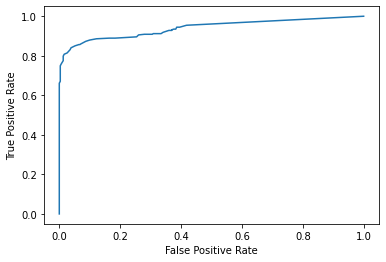

Best Threshold=0.469000
AUC=0.9403102317835708


In [4]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('Best Threshold=%f' % (best_thresh))
print("AUC=" + str(auc))

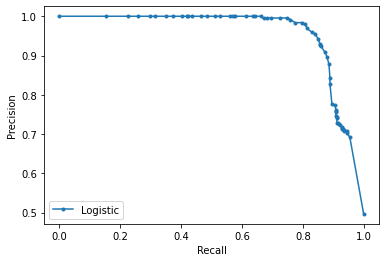

Best Threshold=0.469000, F-Score=0.894


In [5]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
# plot the roc curve for the model
plt.plot(recalls, precisions, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()
# convert to f score
fscore = (2 * precisions * recalls) / (precisions + recalls)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

In [6]:
inferences.clear()
treshold = thresholds[ix]
for line in data:

    if line[0].isdigit():

        startmin = int(line[0:2])
        startsec = int(line[3:5])
        endmin   = int(line[6:8])
        endsec   = int(line[9:11])
        pred     = line[11]

        if pred == "D":
            score = 0
        else:
            score    = float("{:.3f}".format(float(line[13:18])))
        if pred == "N" and score<=(1-treshold):
            pred = "F"
            score = float("{:.3f}".format(1-treshold))
        inf      = Inference(startmin, startsec, endmin, endsec, pred, score)
        inferences.append(inf)

    else:
        continue



frame_index=0

noise_results.clear()
fire_results.clear()
invalid.clear()
uncertain.clear()
max_consecutive_fire_while_fire = 0
max_consecutive_fire_while_noise = 0
consecutive_fire_while_fire.clear()
consecutive_fire_while_noise.clear()
last_consecutive_index = 0
consec_fire = 0


for count, inf in enumerate(inferences):

    if inf.start>=rexpected[frame_index].end:
        while inf.start>=rexpected[frame_index].start:
            if inf.start<rexpected[frame_index].end or (inf.end<=rexpected[frame_index].end and inf.start>=rexpected[frame_index].start):
                break
            frame_index+=1
        consec_fire=1
        last_consecutive_index = count
       
    if (inf.start<rexpected[frame_index].end and inf.end>rexpected[frame_index].end) or rexpected[frame_index].type=="Invalid":
        tuple = ("Invalid", str(inf.start), str(inf.end))
        invalid.append(tuple)
    else:
        tuple = (rexpected[frame_index].type, inf.Fconf, inf.Nconf,str(inf.start),str(inf.end))
        if inf.type=="F":

            consec_fire = 1
            fire_results.append(tuple)

            if count>=last_consecutive_index:

                for i in range(0, len(inferences)-count-1,1):

                    last_consecutive_index += 1

                    if inferences[count+i+1].type == "F" and inferences[count+i+1].start<rexpected[frame_index].end:
                        consec_fire += 1

                    if  inferences[count+i+1].type != "F" or inferences[count+i+1].start>rexpected[frame_index].end or last_consecutive_index >= len(inferences)-1:
                        if rexpected[frame_index].type == "Fire1" or rexpected[frame_index].type == "Fire2" or rexpected[frame_index].type == "Fire3":
                            if consec_fire > max_consecutive_fire_while_fire:
                                max_consecutive_fire_while_fire=consec_fire
                            consecutive_fire_while_fire.append(consec_fire)
                        elif rexpected[frame_index].type == "Noise":
                            if consec_fire > max_consecutive_fire_while_noise:
                                max_consecutive_fire_while_noise=consec_fire
                            consecutive_fire_while_noise.append(consec_fire)
                        break



        elif inf.type=="N":
            noise_results.append(tuple)
            last_consecutive_index += 1
        elif inf.type=="D":
            uncertain.append(tuple)
            last_consecutive_index += 1
        if count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type != "Noise":
            consecutive_fire_while_fire.append(1)
        elif count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type == "Noise":
            consecutive_fire_while_noise.append(1)
#Di seguito le funzioni per calcolare le statistiche sulle inferenze del programma


inf_while_fire  = 0 #conta le inferenze totali fatte su audio di tipo fuoco
inf_while_noise = 0 # conta le inferenze totali fatte su audio di tipo noise
inf_while_fire1  = 0
inf_while_fire2  = 0
inf_while_fire3  = 0

noise_while_fire1 = 0

uncertain_while_fire  = 0
uncertain_while_noise = 0

avg_fire_while_fire.clear()
avg_noise_while_noise.clear()

avg_fire_while_fire3.clear()
avg_fire_while_fire2.clear()
avg_fire_while_fire1.clear()

avg_noise_while_fire.clear()
avg_fire_while_noise.clear()

#calcolo le inferenze totali fatte su audio di tipo fuoco o noise
          
for i in range(0,len(fire_results),1):

    if fire_results[i][0] == "Fire1" or fire_results[i][0] == "Fire2" or fire_results[i][0] == "Fire3":
        
        inf_while_fire  += 1
        avg_fire_while_fire.append(fire_results[i][1])

        if fire_results[i][0] == "Fire1":
            inf_while_fire1  += 1
            avg_fire_while_fire1.append(fire_results[i][1])
        if fire_results[i][0] == "Fire2":
            inf_while_fire2+=1
            avg_fire_while_fire2.append(fire_results[i][1])
        if fire_results[i][0] == "Fire3":
            inf_while_fire3+=1
            avg_fire_while_fire3.append(fire_results[i][1])

    elif fire_results[i][0] == "Noise":
        
        inf_while_noise  += 1
        avg_fire_while_noise.append(fire_results[i][1])

for i in range(0,len(noise_results),1):

    if   noise_results[i][0] == "Fire1" or noise_results[i][0] == "Fire2" or noise_results[i][0] == "Fire3":
        
        inf_while_fire   += 1
        avg_noise_while_fire.append(noise_results[i][2])

        if noise_results[i][0] == "Fire1":
            inf_while_fire1+=1
            noise_while_fire1+=1
        if noise_results[i][0] == "Fire2":
            inf_while_fire2+=1
        if noise_results[i][0] == "Fire3":
            inf_while_fire3+=1

    elif noise_results[i][0] == "Noise":
        
        inf_while_noise += 1
        avg_noise_while_noise.append(noise_results[i][2])


for i in range(0,len(uncertain),1):

    if  uncertain[i][0] == "Fire1" or uncertain[i][0] == "Fire2" or uncertain[i][0] == "Fire3":
        inf_while_fire +=  1
        uncertain_while_fire += 1

    elif uncertain[i][0] == "Noise":
        inf_while_noise += 1
        uncertain_while_noise += 1

mean_fire_while_fire   = avg(avg_fire_while_fire)
mean_noise_while_noise = avg(avg_noise_while_noise)
mean_fire_while_fire1  = avg(avg_fire_while_fire1)
mean_fire_while_fire2  = avg(avg_fire_while_fire2)
mean_fire_while_fire3  = avg(avg_fire_while_fire3)
mean_noise_while_fire  = avg(avg_noise_while_fire)
mean_fire_while_noise  = avg(avg_fire_while_noise)

fire3_perc = 0
fire2_perc = 0
fire1_perc = 0
valid_perc = 0
good_fire_percentage = 0
bad_fire_percentage  = 0
good_noise_percentage = 0
bad_noise_percentage = 0
uncertain_percentage = 0
uncertain_fire_percentage = 0
uncertain_noise_percentage = 0

true_positives = len(avg_fire_while_fire)
true_positives_nof1 = len(avg_fire_while_fire) - len(avg_fire_while_fire1)
true_negatives = len(avg_noise_while_noise)
false_positives = len(avg_fire_while_noise)
false_negatives = len(avg_noise_while_fire)
false_negatives_nof1 = len(avg_noise_while_fire) - noise_while_fire1
tot_inferences     = len(inferences) #numero totale di inferenze (valide e non)
valid_inferences   = len(inferences)-len(invalid)


if tot_inferences != 0:
    valid_perc         = float("{:.1f}".format((valid_inferences/tot_inferences)*100))
if inf_while_fire != 0:
    fire_accuracy  = float("{:.1f}".format((true_positives/inf_while_fire)*100))
    fire_accuracy_nof1  = float("{:.1f}".format((true_positives_nof1/(inf_while_fire-inf_while_fire1))*100))
    false_negatives_percentage   = float("{:.1f}".format((false_negatives/inf_while_fire)*100))
    uncertain_fire_percentage  = float("{:.1f}".format((uncertain_while_fire/inf_while_fire)*100))
if inf_while_noise != 0:
    noise_accuracy = float("{:.1f}".format((true_negatives/inf_while_noise)*100))
    false_positives_percentage  = float("{:.1f}".format((false_positives/inf_while_noise)*100))
    uncertain_noise_percentage  = float("{:.1f}".format((float(uncertain_while_noise)/float(inf_while_noise))*100))
if valid_inferences != 0:
    uncertain_percentage  = float("{:.1f}".format((float(uncertain_while_fire + uncertain_while_noise)/float(valid_inferences))*100))
if (inf_while_fire + inf_while_noise) != 0:
    accuracy = float("{:.1f}".format(((true_positives + true_negatives)/(inf_while_fire + inf_while_noise))*100))
    accuracy_nof1 = float("{:.1f}".format((fire_accuracy_nof1+noise_accuracy)/2))
if (false_positives + false_negatives) !=0:
    recall = float("{:.1f}".format((true_positives/(true_positives+false_negatives))*100))
    recall_nof1 = float("{:.1f}".format((true_positives_nof1/(true_positives_nof1 + false_negatives_nof1))*100))
if (true_positives + false_positives) != 0:
    precision = float("{:.1f}".format((true_positives/(true_positives+false_positives))*100))
    precision_nof1 = float("{:.1f}".format((true_positives_nof1/(true_positives_nof1+false_positives))*100))
if recall != 0 and precision != 0:
    F1 = float("{:.1f}".format((2/((1/recall)+(1/precision)))))
    F1_nof1 = float("{:.1f}".format((2/((1/recall_nof1)+(1/precision_nof1)))))

if inf_while_fire3 != 0:
    fire3_perc         = float("{:.1f}".format((len(avg_fire_while_fire3)/inf_while_fire3)*100))
if inf_while_fire2 != 0:
    fire2_perc         = float("{:.1f}".format((len(avg_fire_while_fire2)/inf_while_fire2)*100))
if inf_while_fire1 != 0:
    fire1_perc         = float("{:.1f}".format((len(avg_fire_while_fire1)/inf_while_fire1)*100))

def color(value):
    if value >0:
        value = "\033[92m\033[1m"+str(value)+"\033[0m"
    elif value <0:
        value = "\033[91m\033[1m"+str(value)+"\033[0m"
    else:
        value = "\033[1m"+str(value)+"\033[0m"
    return value

deltas = [accuracy_nof1,accuracy,recall_nof1,recall,precision_nof1,precision,F1_nof1,F1,fire_accuracy_nof1,fire_accuracy,mean_fire_while_fire,false_neg_perc,false_negatives_percentage,mean_noise_while_fire,noise_accuracy,mean_noise_while_noise,false_positives_percentage,mean_fire_while_noise,fire3_perc,fire2_perc,fire1_perc,max_consecutive_fire_while_fire,avg(consecutive_fire_while_fire),max_consecutive_fire_while_noise,avg(consecutive_fire_while_noise)]

for i in range (0, len(deltas),1):
    deltas[i] =  float("{:.3f}".format(deltas[i] - previous_results[i]))
    deltas[i] = color(deltas[i])
    
false_neg_perc = float("{:.1f}".format(((false_negatives-noise_while_fire1)/(inf_while_fire-inf_while_fire1))*100))
print( "Optimal treshold found: " + str(treshold))
print( "Accuracy:  " + str (accuracy_nof1) + "(" + deltas[0] + ") - Including ENT: " + str(accuracy) + "(" + deltas[1] + ")\nRecall:    " + str(recall_nof1) + "(" + deltas[2] + ") - Including ENT: " + str(recall) + "(" + deltas[3] + ")\nPrecision: " + str(precision_nof1)  + "(" + deltas[4] + ")- Including ENT: " + str(precision) + "(" + deltas[5] + ")\nF1:        " + str(F1_nof1)  + "(" + deltas[6] + ") - Including ENT: " + str(F1) + "(" + deltas[7] + ")\n")
print("Fire Accuracy: " +str(fire_accuracy_nof1) + "(" + deltas[8] + ") - Including ENT: " +str(fire_accuracy) + "(" + deltas[9] + "), mean confidence: " + str(mean_fire_while_fire)+ "(" + deltas[10] + ")")
print("False negatives:    "+ str(false_neg_perc) + "(" + deltas[11] + ") - Including ENT: " +str(false_negatives_percentage) + "(" + deltas[12] + "), mean confidence:" + str(mean_noise_while_fire)+ "(" + deltas[13] + ")\n")
print("Noise accuracy:  " + str(noise_accuracy) + "(" + deltas[14] + "), mean confidence: " + str(mean_noise_while_noise)+ "(" + deltas[15] + ")")
print("False positives: " + str(false_positives_percentage) + "(" + deltas[16] + "), mean confidence: " + str(mean_fire_while_noise)+ "(" + deltas[17] + ")\n")
print("Fire volume dominance accuracy: " + str (fire3_perc)+ "(" + deltas[18] + ")")
print("Fire = Noise volume accuracy:  " + str (fire2_perc)+ "(" + deltas[19] + ")")
print("ENT accuracy: " + str (fire1_perc)+"(" + deltas[20] + ")")

print("\nMax cons. fire while fire: " + str(max_consecutive_fire_while_fire)+ "(" + deltas[21] + ") and avg. cons. " + str(avg(consecutive_fire_while_fire))+ "(" + deltas[22] + ")")
print("Max cons. fire while noise: " + str(max_consecutive_fire_while_noise)+ "(" + deltas[23] + ") and avg. cons. " + str(avg(consecutive_fire_while_noise)) + "(" + deltas[24] + ")\n\n")



Optimal treshold found: 0.469
Accuracy:  92.8(0.3) - Including ENT: 89.7(0.3)
Recall:    90.6(0.9) - Including ENT: 84.0(0.9)
Precision: 94.4(-0.4)- Including ENT: 95.6(-0.3)
F1:        92.5(0.3) - Including ENT: 89.4(0.4)

Fire Accuracy: 90.2(0.9) - Including ENT: 83.8(1.0), mean confidence: 0.898(-0.004)
False negatives:    9.3(0.0) - Including ENT: 15.9(-1.0), mean confidence:0.865(0.019)

Noise accuracy:  95.5(-0.3), mean confidence: 0.928(0.001)
False positives: 3.8(0.3), mean confidence: 0.602(-0.007)

Fire volume dominance accuracy: 92.9(0.7)
Fire = Noise volume accuracy:  86.7(1.2)
ENT accuracy: 66.3(1.2)

Max cons. fire while fire: 42(0.0) and avg. cons. 7.081(-0.086)
Max cons. noise while noise: 2(0.0) and avg. cons. 1.2(0.1)


